In [25]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math

# Tensorflow/keras imports
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from category_encoders import BinaryEncoder

import seaborn as sns

Data Import and Preprocessing

In [1]:
# Function for removing correlated features
def remove_correlated_features(X_train: pd.DataFrame, X_test: pd.DataFrame, threshold: float) -> None:
    corr_matrix = X_train.corr(numeric_only = True)
    sns.heatmap(corr_matrix)
    plt.title("Features Correlation")
    plt.show()
    drop_cols = []
    # Iterate through the correlation matrix and compare correlations
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print("Correlated features: ", col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    X_train.drop(columns=drops, inplace=True)
    X_test.drop(columns=drops, inplace=True)
    print('Removed Columns {}'.format(drops))

def display_confusion_matrix(y_pred, y_test) -> None:
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=np.unique(y_test))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test)).plot(cmap='Blues')
    plt.show()

NameError: name 'pd' is not defined

Samples in X_train: 175341
Samples in X_test: 82332
Correlated features:  sloss | sbytes | 1.0
Correlated features:  dloss | dbytes | 1.0
Correlated features:  dwin | swin | 0.99
Correlated features:  ct_ftp_cmd | is_ftp_login | 1.0
Correlated features:  ct_srv_dst | ct_srv_src | 0.98
Removed Columns {'dwin', 'dloss', 'sloss', 'ct_ftp_cmd', 'ct_srv_dst'}


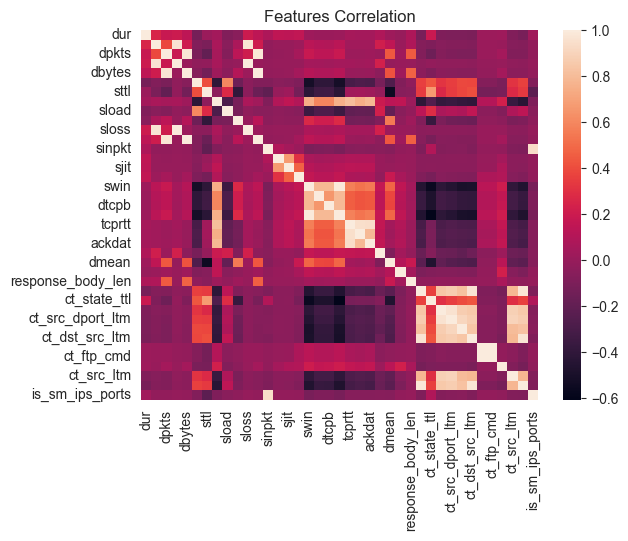

Categorical features: ['proto', 'service', 'state']
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports']
Number of features after preprocessing: 50


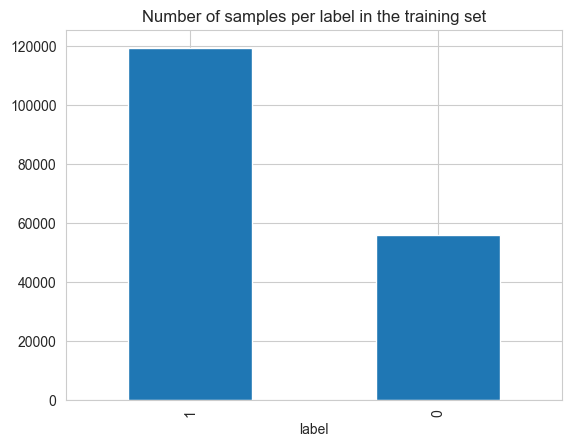

In [20]:
# Data files
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

X_train = train_df.drop(columns=['id', 'attack_cat'])
y_train = X_train.pop("label")
X_test = test_df.drop(columns=["id", "attack_cat"])
y_test = X_test.pop("label")

print(f"Samples in X_train: {len(X_train)}")
print(f"Samples in X_test: {len(X_test)}")

remove_correlated_features(X_train, X_test, 0.98)

# Encode categorical features using binary encoding
# Scale numerical features using standard scaler
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), num_features),
        ("categorical", BinaryEncoder(handle_unknown="ignore"), cat_features)
    ], sparse_threshold=0
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(f"Number of features after preprocessing: {X_train.shape[1]}")

# Use class weights to balance the classes for the training set
y_train.value_counts().plot.bar()
plt.title("Number of samples per label in the training set")
plt.show()

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Neural Network

In [13]:
# Hyperparameters
epochs = 5
batch_size = 32
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model
model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(51, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 51)             │         2,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,238 (12.65 KB)

 Trainable params: 3,238 (12.65 KB)

 Non-trainable params: 0 (0.00 B)

Experimental RNN (don't run)

In [14]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
model = Sequential([
    # layers.Input(shape=X_train.shape),
    layers.LSTM(40, return_sequences=True),
    layers.Dropout(0.1),
    layers.LSTM(30, return_sequences=True),
    layers.Dropout(0.1),
    layers.LSTM(30, return_sequences=True),
    layers.Dropout(0.1),
    layers.LSTM(20, return_sequences=False),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile model
model.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

# Train model with proper callback
model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model.evaluate(X_test, y_test))

# Display confusion matrix
display_confusion_matrix(model.predict(X_test, verbose=0).flatten(), y_test)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/5


2024-04-15 04:45:27.059997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4384/4384 ━━━━━━━━━━━━━━━━━━━━ 146s 31ms/step - accuracy: 0.5777 - loss: 0.6146 - val_accuracy: 0.9985 - val_loss: 0.2031 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/5
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 125s 29ms/step - accuracy: 0.8788 - loss: 0.3104 - val_accuracy: 0.9273 - val_loss: 0.2874 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/5
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 126s 29ms/step - accuracy: 0.8837 - loss: 0.2980 - val_accuracy: 0.9986 - val_loss: 0.1104 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/5
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 136s 31ms/step - accuracy: 0.8855 - loss: 0.2489 - val_accuracy: 0.8689 - val_loss: 0.1395 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/5
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 133s 30ms/step - accuracy: 0.8844 - loss: 0.2459 - val_accuracy: 0.9835 - val_loss: 0.0589 - 

[0.32470908761024475, 0.8241752982139587]

Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000, class_weight=class_weights).fit(X_train, y_train)
print(clf.score(X_test, y_test))
display_confusion_matrix(clf, clf.predict(X_test), y_test)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Ensembles

0.8727833649127921


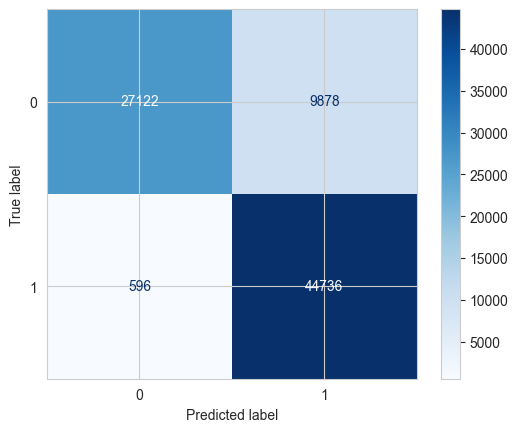

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight=class_weights).fit(X_train, y_train)
print(clf.score(X_test, y_test))
display_confusion_matrix(clf.predict(X_test), y_test)

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))
display_confusion_matrix(clf.predict(X_test), y_test)